In [16]:
from sklearn.datasets import load_svmlight_file
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train = load_svmlight_file('a9a.txt')
test = load_svmlight_file('a9a.t')
X_train = train[0]
y_train = train[1]
X_test = test[0]
y_test = test[1]

X_train1,X_train,y_train1,y_train = train_test_split(X_train,y_train,test_size=0.1,random_state=100)
X_test1,X_test,y_test1,y_test = train_test_split(X_test,y_test,test_size=0.1,random_state=100)

y_train = map(lambda x: x if x==1 else 0, y_train)
y_test = map(lambda x: x if x==1 else 0, y_test)

X_train = X_train.todense()
y_train = np.mat(y_train).T
X_test = X_test.todense()
y_test = np.mat(y_test).T

X_train = np.column_stack((X_train, [1 for i in range(X_train.shape[0])]))
X_test = np.column_stack((X_test, [0 for i in range(X_test.shape[0])]))
X_test = np.column_stack((X_test, [1 for i in range(X_test.shape[0])]))

def lossFunc(w,x,y):
    m = x.shape[0]
    C = 1
    tot = 0.0
    for i in range(m):
        tot = tot + max(0,1-y[i]*(w*x[i].T))
    return np.double(w*w.T + C * tot)/y.shape[0]

#无优化
def SGD(X_train, X_test, y_train, y_test):
    Loss_train = []
    Loss_test = []
    epochs = 200
    learning_rate = 0.01
    w = np.mat(np.zeros(X_train.shape[1]))
    for i in range(epochs):
        loss_train = lossFunc(w,X_train,y_train)
        loss_test = lossFunc(w,X_test,y_test)
        print "%d\tloss_train%f\tloss_test%f"%(i,loss_train,loss_test)
        Loss_train.append(loss_train)
        Loss_test.append(loss_test)
        r = np.random.randint(0,X_train.shape[0]-20)
        tot = np.mat(np.zeros(X_train.shape[1]))
        for i in range(X_train.shape[0]):
            if 1 - y_train[i]*(w*X_train[i].T) > 0:
                tot+=X_train[i]*np.double(y_train[i])
        tot = w - tot
        w -= learning_rate*tot
    return Loss_train,Loss_test

#NAG
def SGD_NAG(X_train, X_test, y_train, y_test):
    Loss_train = []
    Loss_test = []
    epochs = 200
    learning_rate = 0.01
    gama = 0.001
    w = np.mat(np.zeros(X_train.shape[1]))
    v = np.mat(np.zeros(X_train.shape[1]))
    for i in range(epochs):
        loss_train = lossFunc(w,X_train,y_train)
        loss_test = lossFunc(w,X_test,y_test)
        print "%d\tloss_train%f\tloss_test%f"%(i,loss_train,loss_test)
        Loss_train.append(loss_train)
        Loss_test.append(loss_test)
        r = np.random.randint(0,X_train.shape[0]-20)
        temp = w-gama*v
        g = np.mat(np.zeros(X_train.shape[1]))
        for i in range(20):
            if 1 - y_train[r+i]*(temp*X_train[r+i].T) > 0:
                g+=X_train[r+i]*np.double(y_train[r+i])
        g = w - g
        v = gama*v + learning_rate*g
        w -= v
    return Loss_train,Loss_test

#RMSProp
def SGD_RMSProp(X_train, X_test, y_train, y_test):
    Loss_train = []
    Loss_test = []
    epochs = 200
    learning_rate = 0.01
    gama = 0.9
    epxl = 1e-8
    w = np.mat(np.zeros(X_train.shape[1]))
    G = np.mat(np.zeros(X_train.shape[1]))
    for i in range(epochs):
        loss_train = lossFunc(w,X_train,y_train)
        loss_test = lossFunc(w,X_test,y_test)
        print "%d\tloss_train%f\tloss_test%f"%(i,loss_train,loss_test)
        Loss_train.append(loss_train)
        Loss_test.append(loss_test)
        r = np.random.randint(0,X_train.shape[0]-20)
        g = np.mat(np.zeros(X_train.shape[1]))
        for i in range(20):
            if 1 - y_train[r+i]*(w*X_train[r+i].T) > 0:
                g+=X_train[r+i]*np.double(y_train[r+i])
        g = w - g
        G = gama * G + (1-gama)*np.multiply(g,g)
        w -= np.multiply(learning_rate/np.sqrt(G+epxl),g)
    return Loss_train,Loss_test

#AdaDelta
def SGD_AdaDelta(X_train, X_test, y_train, y_test):
    Loss_train = []
    Loss_test = []
    epochs = 200
    learning_rate = 0.01
    gama = 0.95
    epxl = 1e-8
    w = np.mat(np.zeros(X_train.shape[1]))
    G = np.mat(np.zeros(X_train.shape[1]))
    deltaT = np.mat([0.001 for i in range(X_train.shape[1])])
    for i in range(epochs):
        loss_train = lossFunc(w,X_train,y_train)
        loss_test = lossFunc(w,X_test,y_test)
        print "%d\tloss_train%f\tloss_test%f"%(i,loss_train,loss_test)
        Loss_train.append(loss_train)
        Loss_test.append(loss_test)
        r = np.random.randint(0,X_train.shape[0]-20)
        g = np.mat(np.zeros(X_train.shape[1]))
        for i in range(20):
            if 1 - y_train[r+i]*(w*X_train[r+i].T) > 0:
                g+=X_train[r+i]*np.double(y_train[r+i])
        g = w - g
        G = gama * G + (1-gama)*np.multiply(g,g)
        deltaW = np.multiply(np.sqrt(deltaT+epxl)/np.sqrt(G+epxl),g)
        w -= deltaW
        deltaT = gama*deltaT+(1-gama)*np.multiply(deltaW,deltaW)
    return Loss_train,Loss_test

#Adam
def SGD_Adam(X_train, X_test, y_train, y_test):
    Loss_train = []
    Loss_test = []
    epochs = 200
    learning_rate = 0.001
    gama = 0.999
    beta = 0.9
    epxl = 1e-8
    w = np.mat(np.zeros(X_train.shape[1]))
    G = np.mat(np.zeros(X_train.shape[1]))
    m = np.mat(np.zeros(X_train.shape[1]))    
    for i in range(epochs):
        loss_train = lossFunc(w,X_train,y_train)
        loss_test = lossFunc(w,X_test,y_test)
        print "%d\tloss_train%f\tloss_test%f"%(i,loss_train,loss_test)
        Loss_train.append(loss_train)
        Loss_test.append(loss_test)
        r = np.random.randint(0,X_train.shape[0]-20)
        g = np.mat(np.zeros(X_train.shape[1]))
        for i in range(20):
            if 1 - y_train[r+i]*(w*X_train[r+i].T) > 0:
                g+=X_train[r+i]*np.double(y_train[r+i])
        g = w - g
        m = beta*m+(1-beta)*g
        G = gama * G + (1-gama)*np.multiply(g,g)
        alpha = learning_rate*np.sqrt(1-np.power(gama,i+1))/(1-np.power(beta,i+1))
        w -= alpha*m/np.sqrt(G+epxl)
    return Loss_train,Loss_test

Loss_train,Loss_test = SGD(X_train, X_test, y_train, y_test)
Loss_train_NAG,Loss_test_NAG = SGD_NAG(X_train, X_test, y_train, y_test)
Loss_train_RMS,Loss_test_RMS = SGD_RMSProp(X_train, X_test, y_train, y_test)
Loss_train_AD,Loss_test_AD = SGD_AdaDelta(X_train, X_test, y_train, y_test)
Loss_train_ADAM,Loss_test_ADAM = SGD_Adam(X_train, X_test, y_train, y_test)

0	loss_train1.000000	loss_test1.000000
1	loss_train0.910142	loss_test1.045632
2	loss_train0.907293	loss_test1.039935
3	loss_train0.904501	loss_test1.034351
4	loss_train0.901764	loss_test1.028879
5	loss_train0.899081	loss_test1.023516
6	loss_train0.896452	loss_test1.018259
7	loss_train0.893875	loss_test1.013107
8	loss_train0.891350	loss_test1.008057
9	loss_train0.888874	loss_test1.003108
10	loss_train0.886448	loss_test0.998258
11	loss_train0.884071	loss_test0.993504
12	loss_train0.881740	loss_test0.988844
13	loss_train0.879456	loss_test0.984278
14	loss_train0.877217	loss_test0.979802
15	loss_train0.875023	loss_test0.975415
16	loss_train0.872873	loss_test0.971116
17	loss_train0.870765	loss_test0.966902
18	loss_train0.868700	loss_test0.962772
19	loss_train0.866675	loss_test0.958724
20	loss_train0.864691	loss_test0.954757
21	loss_train0.862746	loss_test0.950868
22	loss_train0.860840	loss_test0.947057
23	loss_train0.858972	loss_test0.943322
24	loss_train0.857141	loss_test0.939661
25	loss_tr

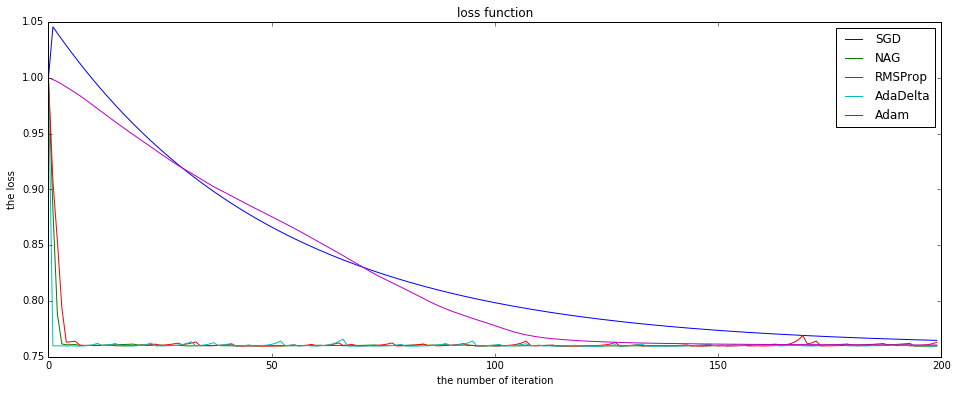

In [17]:
fig = plt.figure(figsize=(16,6))
plt.title('loss function')
plt.xlabel('the number of iteration')
plt.ylabel('the loss')
ax = fig.add_subplot(111)
ax.plot(range(0,len(Loss_test)),Loss_test,label='SGD')
ax.plot(range(0,len(Loss_test_NAG)),Loss_test_NAG,label='NAG')
ax.plot(range(0,len(Loss_test_RMS)),Loss_test_RMS,label='RMSProp')
ax.plot(range(0,len(Loss_test_AD)),Loss_test_AD,label='AdaDelta')
ax.plot(range(0,len(Loss_test_ADAM)),Loss_test_ADAM,label='Adam')
plt.legend()
plt.show()